In [1]:
# Standard library imports
import copy
import os

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from skimage import io, transform
from sklearn.metrics import confusion_matrix
from torchvision import datasets, models, transforms


In [2]:
PATH_RESIZED = "../data/resized"
PATH_TRAIN = f"{PATH_RESIZED}/train"
PATH_TEST = f"{PATH_RESIZED}/test"
TRAIN_0_PATH = f"{PATH_TRAIN}/normal"
TRAIN_1_PATH = f"{PATH_TRAIN}/pneumonia"
TEST_0_PATH = f"{PATH_TEST}/normal"
TEST_1_PATH = f"{PATH_TEST}/pneumonia"

In [3]:
print(f"Version: {torch.__version__}, GPU: {torch.cuda.is_available()}, NUM_GPU: {torch.cuda.device_count()}")

Version: 2.3.1, GPU: True, NUM_GPU: 1


In [4]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Print GPU details
if cuda_available:
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
GPU device name: NVIDIA GeForce RTX 4060 Ti


In [5]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor()])

# Load your dataset
train_dataset = datasets.ImageFolder(PATH_TRAIN, transform=transform)
test_dataset = datasets.ImageFolder(PATH_TEST, transform=transform)

In [6]:
# How many samples are there? 
len(train_dataset), len(train_dataset.targets), len(test_dataset), len(test_dataset.targets)

(5200, 5200, 1298, 1298)

In [7]:
class_names = train_dataset.classes
class_names

['normal', 'pneumonia']

Image shape: torch.Size([3, 224, 224])


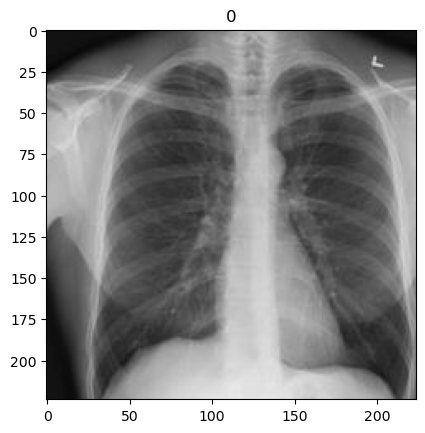

In [8]:
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")

image = image.permute(1, 2, 0)

plt.imshow(image.squeeze())
plt.title(label)
plt.show()

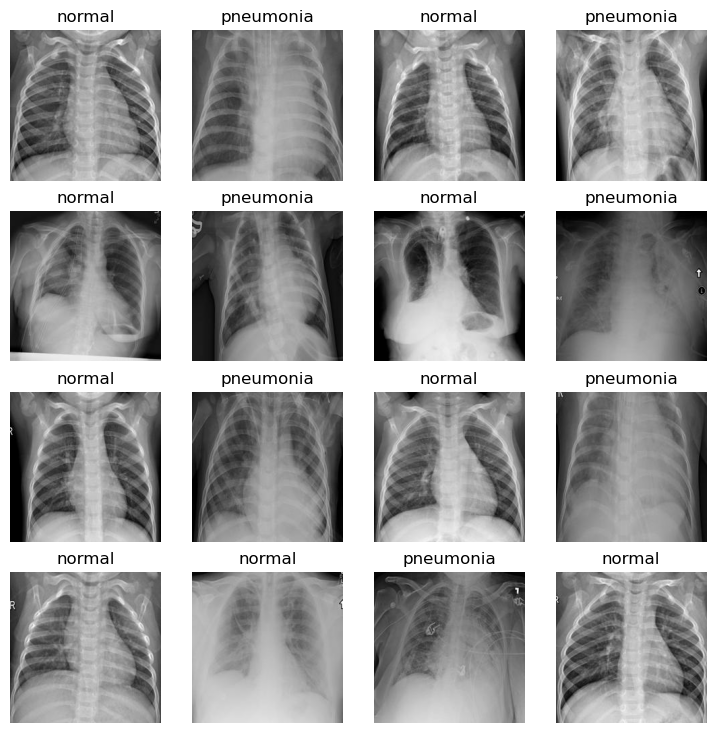

In [9]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [10]:
# Create DataLoader
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [11]:
res_mod = models.resnet50(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

c:\ProgramData\anaconda3\envs\scorpion\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\scorpion\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
res_mod = res_mod.to(device)

# 2 - Define our loss function
criterion = nn.CrossEntropyLoss()

# 3 - Optmization - Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
dataloaders = {"train": trainloader, "test": testloader}

In [16]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'test']}

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    list_train_loss = [] 
    list_train_acc = [] 
    list_val_loss = []
    list_val_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                # Set model to training mode
                model.train()  
            else:
                # Set model to evaluate mode
                model.eval()  

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            #register to output lists
            if phase == 'train':
              list_train_loss.append(epoch_loss)
              list_train_acc.append(epoch_acc)
            if phase == 'val':
              list_val_loss.append(epoch_loss)
              list_val_acc.append(epoch_acc)

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        # Variables to be written on tensorboard!
        #writer.add_scalar('Loss/train', epoch_loss/len(trainloader), epoch)

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [18]:
base_model, train_loss, train_acc, val_loss, val_acc = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
Iterating through data...


c:\ProgramData\anaconda3\envs\scorpion\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5550 Acc: 0.9258
Iterating through data...
test Loss: 18.6660 Acc: 0.5000

Epoch 1/9
----------
Iterating through data...
train Loss: 3.8959 Acc: 0.5308
Iterating through data...
test Loss: 4.3600 Acc: 0.5000

Epoch 2/9
----------
Iterating through data...
train Loss: 0.9925 Acc: 0.4198
Iterating through data...
test Loss: 2.1510 Acc: 0.5000

Epoch 3/9
----------
Iterating through data...
train Loss: 0.8335 Acc: 0.4973
Iterating through data...
test Loss: 2.3542 Acc: 0.5000

Epoch 4/9
----------
Iterating through data...
train Loss: 0.9941 Acc: 0.4085
Iterating through data...
test Loss: 4.6407 Acc: 0.5000

Epoch 5/9
----------
Iterating through data...
train Loss: 0.8798 Acc: 0.3969
Iterating through data...
test Loss: 10.4252 Acc: 0.5000

Epoch 6/9
----------
Iterating through data...
train Loss: 0.8216 Acc: 0.5000
Iterating through data...
test Loss: 8.0296 Acc: 0.5000

Epoch 7/9
----------
Iterating through data...
train Loss: 0.7777 Acc: 0.5000
Iterating through data

In [19]:
import torch.nn.functional as F


In [20]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(trainloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/30, Loss: 7.7303
Epoch 2/30, Loss: 2.5254
Epoch 3/30, Loss: 3.6565
Epoch 4/30, Loss: 3.2211
Epoch 5/30, Loss: 2.8476
Epoch 6/30, Loss: 3.9326
Epoch 7/30, Loss: 1.3929
Epoch 8/30, Loss: 0.6993
Epoch 9/30, Loss: 0.6990
Epoch 10/30, Loss: 0.6989
Epoch 11/30, Loss: 0.6989
Epoch 12/30, Loss: 0.6988
Epoch 13/30, Loss: 0.6987
Epoch 14/30, Loss: 0.6987
Epoch 15/30, Loss: 0.6986
Epoch 16/30, Loss: 0.6987
Epoch 17/30, Loss: 0.6986
Epoch 18/30, Loss: 0.6986
Epoch 19/30, Loss: 0.6986
Epoch 20/30, Loss: 0.6986
Epoch 21/30, Loss: 0.6986
Epoch 22/30, Loss: 0.6987
Epoch 23/30, Loss: 0.6986
Epoch 24/30, Loss: 0.6986
Epoch 25/30, Loss: 0.6986
Epoch 26/30, Loss: 0.6986
Epoch 27/30, Loss: 0.6986
Epoch 28/30, Loss: 0.6986
Epoch 29/30, Loss: 0.6986
Epoch 30/30, Loss: 0.6986


In [23]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.5000
